### SMS and Email Spam Classifier using Logistic Regression and Gradient Descent (only numpy)
#### (Applying Gradient Descent only with numpy)

#### Gracient Descent
The gradient helps us maximize a function. So, gradient descent (negative gradient) helps us minimize a function when a global minimum exists.

The data was obtained from:<br>
__Dua, D. and Graff, C. (2019). UCI Machine Learning Repository (https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection). Irvine, CA: University of California, School of Information and Computer Science.__<br>

Abstract: The SMS Spam Collection is a public set of SMS labeled messages that have been collected for mobile phone spam research.<br>

Examples:<br>
__ham__ What you doing?how are you?<br>
__ham__ Ok lar... Joking wif u oni...<br>
__ham__ dun say so early hor... U c already then say...<br>
__ham__ MY NO. IN LUTON 0125698789 RING ME IF UR AROUND! H*<br>
__ham__ Siva is in hostel aha:-.<br>
__ham__ Cos i was out shopping wif darren jus now n i called him 2 ask wat present he wan lor. Then he started guessing who i was wif n he finally guessed darren lor.<br>
__spam__ FreeMsg: Txt: CALL to No: 86888 & claim your reward of 3 hours talk time to use from your phone now! ubscribe6GBP/ mnth inc 3hrs 16 stop?txtStop<br>
__spam__ Sunshine Quiz! Win a super Sony DVD recorder if you canname the capital of Australia? Text MQUIZ to 82277. B<br>
__spam__ URGENT! Your Mobile No 07808726822 was awarded a L2,000 Bonus Caller Prize on 02/09/03! This is our 2nd attempt to contact YOU! Call 0871-872-9758 BOX95QU<br>

In [1]:
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import csv

#### Loading Data
Loading data first into spam/no spam so I can decide later which features (words/characters/punctuation) to include.

In [2]:
#Reading file
y_spam=list()
y_no_spam=list()
sms_spam=list()
sms_no_spam=list()

#will also change ham/spam labels to -1/1 to make the math faster when measuring accuracy
with open('SMSSpamCollection', 'r') as file:
    reader = csv.reader(file,delimiter='\t')
    for row in reader:
        if row[0]=='ham':
            y_no_spam.append(-1)
            sms_no_spam.append(row[1])
        else:
            y_spam.append(1)
            sms_spam.append(row[1])

In [3]:
def standardize_data(text):
    # This function will perform some changes to the string received. It will first separate
    #   some characters so that the combination of total words can be reduced significantly.
    #   Then it will remove the stopwords that are always present in sms/emails that doesn't
    #   give relevant information.
    #   List of stopwords was taken from: https://gist.github.com/sebleier/554280 but I removed
    #   some words ('no', 'nor' and 'not').
    # Input: 
    # text : string with complete sms or email message
    # Output:
    # modified_text: string separating characters/words in 'separators' list and removing stop words 
    separators=['-','$','£',':','+','?','!','/','>','<','*','@','http','.com','www','(',')',"'",'.']
    stopwords=["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"]
    text=text.lower()
    for separator in separators:
        text=text.replace(separator, ' ' + separator + ' ')
    text=text.replace("   ", " ")
    text=text.replace("  ", " ")
    modified_text=str()
    for word in text.split():
        if word not in stopwords:
            modified_text=modified_text + word + ' '
    return modified_text.strip()

#### Feature Processing and Selection
The process I will follow is really 'easy'.
 1. Will get the top 5% of the words/characters with more 'hits' in the spam texts/emails.
 2. Will do the same with the no-spam texts.
 3. Will put both in a set (to remove duplicates) named 'features'.

I decided to get only 5% of the top features (total words/characters were around 5k) initially because it had a great balance of enough data and speed.
As you will see, I made different runs with more and less features.

In [4]:
#will generate 2 'big' string. One with all the spam texts concatenated and the other one with all the no-spam ones.
#this texts are the ones that are going to help me determine the features.
spam_text=standardize_data( " ".join(sms_spam) )
no_spam_text=standardize_data( " ".join(sms_no_spam) )

In [5]:
def feature_decision(spam_text,no_spam_text,top):
    # This function receive 2 texts and will select the top features in each.
    # Input:
    # spam_text : string
    # no_spam_text : string
    # top: proportion of top words/characters to include. Example: 0.05 will be the top 5% of the features
    # Output:
    # features: union of the 2 set of words/characters from the spam and no-spam texts

    total = Counter()
    spam = Counter()
    no_spam = Counter()

    for word in spam_text.split():
        spam[word] += 1
        total[word] += 1
    for word in no_spam_text.split():
        no_spam[word] += 1
        total[word] += 1

    spam_most_common=dict(spam.most_common()[0:int(len(spam)*top)])
    no_spam_most_common=dict(no_spam.most_common()[0:int(len(no_spam)*top)])

    top_spam_features=set()
    top_no_spam_features=set()

    for k,v in spam_most_common.items():
        top_spam_features.add(k)

    for k,v in no_spam_most_common.items():
        top_no_spam_features.add(k)

    return (top_spam_features | top_no_spam_features)

In [6]:
#will run the previous function to select some features
features=feature_decision(spam_text,no_spam_text,0.05)
print('Example of items in the set Features:\n')
print(list(features)[0:12])
print(list(features)[-12:])

Example of items in the set Features:

['time', 'draw', 'saw', 'dont', 'watching', 'well', 'dinner', 'stuff', 'new', 'week', 'help', 'princess']
['6', 'start', 'makes', 'chance', 'office', 'still', 'asked', 'line', 'msg', 'always', 'valid', 'til']


#### Creates the vectors according to Features

In [7]:
def create_vector(text,features):
    # Function receives a string and returns the 'vector' with the features count in the text. It will count each
    #   feature word in the text
    # Input:
    # text: string
    # features: features set with top words
    # Output:
    # array: 1 array with n dimensions. Dimensions are equivalent to the size of features set.
    
    text=standardize_data(text)
    dict_features = { i : 0 for i in features }
    for i in text.split():
        try:
            dict_features[i]+=1
        except:
            continue
    return np.array(list(dict_features.values()))

__The following process takes a little bit of time. In my computer takes around 15 seconds (Mac 2019).__

In [8]:
def create_X_datasets(y_spam, sms_spam, y_no_spam, sms_no_spam, features):
    # Function randomly creates training and testing datasets.
    #   1: it creates the vectors. 2: concatenates the y's values.  3: adds a column with random values
    #   4: uses the random values to divide the train from the test arrays.
    # Input:
    # y_spam: list of 1's
    # sms_spam: list with sms/emails spam messages
    # y_no_spam: list of -1's
    # sms_no_spam: list with sms/emails no spam messages
    # features: features set (words/characters we will be looking for)
    # Output:
    # x_train: columns same size as the size of the features. Rows depend, but approximately 70% of total.
    # y_train: 1 column. Same amount of rows than x_train. Values -1 or 1.
    # x_test: columns same size as the size of the features. Rows depend, but approximately 70% of total.
    # y_test: 1 column. Same amount of rows than x_test. Values -1 or 1.
    
    #1: creates vector matrix
    for i in range (len(y_spam)):
        feature_vector=create_vector(sms_spam[i],features)
        feature_vector=feature_vector.reshape(1,feature_vector.shape[0])
        if i == 0:
            X_spam=feature_vector
        else:
            X_spam=np.concatenate([X_spam, feature_vector],axis=0)

    for i in range (len(y_no_spam)):
        feature_vector=create_vector(sms_no_spam[i],features)
        feature_vector=feature_vector.reshape(1,feature_vector.shape[0])
        if i == 0:
            X_no_spam=feature_vector
        else:
            X_no_spam=np.concatenate([X_no_spam, feature_vector],axis=0)

    X=np.concatenate([X_spam, X_no_spam],axis=0)

    #2: concatenates y's
    y=np.concatenate([y_spam, y_no_spam],axis=0)
    X_and_y=np.concatenate([X,y.reshape(y.shape[0],1)],axis=1)

    #3: random numbers column
    random_column = np.array(np.random.rand(len(y)))  #create random column so I can divide train/test sets
    random_column = random_column.reshape(random_column.shape[0],1)
    X_and_y=np.concatenate([X_and_y,random_column],axis=1)
    train=X_and_y[X_and_y[:,-1]<=.7]
    test=X_and_y[X_and_y[:,-1]>.7]

    print("Proportion of data used for training:",round(train.shape[0]/(train.shape[0]+test.shape[0]),3 ))

    #Train features and y
    train=train[:,0:train.shape[1]-1]          #eliminate the random column, we don't need it anymore
    y_train=train[:,-1]                        #get y from dataset (which is now the lat column)
    x_train=train[:,0:train.shape[1]-1]        #eliminating the y column, this is now our feature set

    test=test[:,0:test.shape[1]-1]
    y_test=test[:,-1]
    x_test=test[:,0:test.shape[1]-1]
            
    return x_train, y_train, x_test, y_test

x_train, y_train, x_test, y_test=create_X_datasets(y_spam, sms_spam, y_no_spam, sms_no_spam, features)
print('\nx_train size: ',x_train.shape, '\ty_train size: ',y_train.shape)
print('\nx_test size: ',x_test.shape, '\ty_test size: ',y_test.shape)

Proportion of data used for training: 0.695

x_train size:  (3875, 475) 	y_train size:  (3875,)

x_test size:  (1697, 475) 	y_test size:  (1697,)


#### Gradient Descent Functions and Calculations

In [9]:
def sigmoid(z):
    # Implements sigmoid function. Base 
    # Input: 
    # z : scalar or array of any dimension
    # Output:
    # sgmd: scalar if received a scalar, array if receives an array (same dimensions)
    sgmd = 1 / (1 + np.exp(-z))    
    return sgmd

def y_pred(X, w, b=0):
    # Applies dot product of X and the weight vector. It then adds the bias.
    # This information is used to predict the "probability" of the vector being label spam (1).
    # Input:
    # X: matrix (any size)
    # w: vector with same dimensions as in X
    # b: optional number, if not passed on is treated as 0.
    # Output:
    # prob: n-dimensional vector
    prob=sigmoid(np.dot(X, w)+b)    
    return prob

def log_loss(X, y, w, b=0):
    # Calculates the "probability" (likelihood) of having a label of 1
    # Input:
    # X: matrix
    # y: vector with labels (+1 or -1)
    # w: 1 row vector with same dimensins as X
    # Output:
    # a scalar
    nll=-np.sum(np.log(sigmoid(y*(np.dot(X, w)+b))))
    return nll

def gradient(X, y, w, b):
    # calculates the gradient
    # Input:
    # X: nxd matrix
    # y: n-dimensional vector with labels (+1 or -1)
    # w: d-dimensional vector
    # b: a scalar bias term
    # Output:
    # wgrad: d-dimensional vector with gradient
    # bgrad: a scalar with gradient
    n, d = X.shape
    weight_gradient = np.zeros(d)
    bias_gradient = 0.0
    bias_gradient = np.sum(-y*sigmoid(  -y*(np.dot(X, w)+b)  ) )
    weight_gradient = np.dot((-y*sigmoid(  -y*(np.dot(X, w)+b)  ) ), X)
    return weight_gradient, bias_gradient

def logistic_regression(X, y, iterations, alpha):
    # Run the logistic regression in a fixed amount of iterations. During each iteration it calculates the gradient,
    #   applies it to the weight vector and bias number and calculates the loss.
    # Input:
    # X: matrix
    # y: n-dimensional vector with labels (+1 or -1)
    # iterations: number of iterations 
    # alpha: learning rate (very small number will take too long to find global minimum, too big will
    #   never find it because it will be "bouncing back")
    # Output:
    # w: final weight vector
    # b: bias number
    # losses: list with calculated log-likelihood
    n, d = X.shape
    w = np.zeros(d)
    b = 0.0
    losses = np.zeros(iterations)
    
    for step in range(iterations):
        wstep,bstep=gradient(X, y, w, b)
        w-=alpha*wstep
        b-=alpha*bstep
        losses[step]=log_loss(X, y, w, b)
    return w, b, losses

#### Running the Logistic Regression with Gradient Descent
Tried different combinations of variables (size of alpha, number of iterations and amount of features).
Also tried to have a variable alpha that was decreasing with iterations with no 'better' much success.

In [10]:
#features=feature_decision(spam_text,no_spam_text,0.05)  #already loaded before, don't need to run it again
weight, b, losses = logistic_regression(x_train, y_train, 2000, 0.0008)  #5% top features/iterations 2000/alpha 0.0008

Text(0, 0.5, 'Loss value')

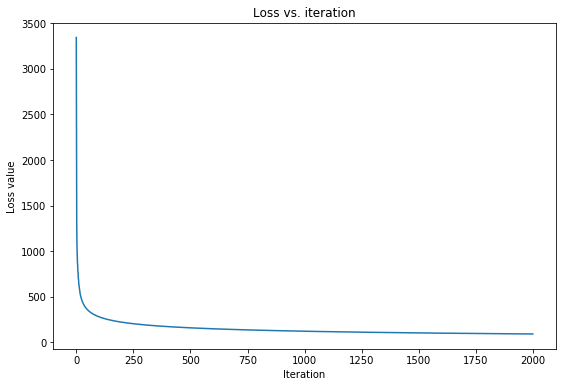

In [11]:
plt.figure(figsize=(9, 6))
plt.plot(losses)
plt.title("Loss vs. iteration", size=12)
plt.xlabel("Iteration", size=10)
plt.ylabel("Loss value", size=10)

#### Measuring and Calibrating Accuracy with Different Inputs

In [12]:
def calculate_accuracy(x_test, weight, b):
    # Calculates accuracy of predictions
    # Input:
    # x_test: matrix with features
    # weight: vector with final weights
    # b: final bias
    # Output:
    # accuracy: measured from 0 to 1 and multiplied by 100 to get a percentage
    scores = y_pred(x_test, weight, b)
    pred_labels = (scores > 0.5).astype(int)
    pred_labels[pred_labels != 1] = -1
    accuracy = np.mean(pred_labels==y_test)
    
    actual_no_pred_no=0
    actual_yes_pred_yes=0
    actual_no_pred_yes=0
    actual_yes_pred_no=0
    
    for i in range(scores.shape[0]):
        if y_test[i]==pred_labels[i]:
            if y_test[i]==-1:
                actual_no_pred_no+=1
            else:
                actual_yes_pred_yes+=1
        else:
            if y_test[i]==-1:
                actual_no_pred_yes+=1
            else:
                actual_yes_pred_no+=1
    print('\nCONFUSION MATRIX\n')
    print('\t PREDICTED')
    print('ACTUAL\t NO\tYES')
    print('------------------------------')
    print('NO SPAM\t',actual_no_pred_no,'\t',actual_no_pred_yes)
    print('SPAM\t',actual_yes_pred_no,'\t',actual_yes_pred_yes)
    print('\n')
    print("Error to minimize (Not spam classified as spam):",round((100*actual_no_pred_yes)/(actual_no_pred_no+actual_yes_pred_yes+actual_no_pred_yes+actual_yes_pred_no),2),'%')

    return accuracy

In [13]:
print('Features: ', len(features), '\t\tAccuracy (%): ',round(100*calculate_accuracy(x_test, weight, b),2))


CONFUSION MATRIX

	 PREDICTED
ACTUAL	 NO	YES
------------------------------
NO SPAM	 1461 	 5
SPAM	 20 	 211


Error to minimize (Not spam classified as spam): 0.29 %
Features:  475 		Accuracy (%):  98.53


In [14]:
#Run with less features (top 2%), 2000 iterations and alpha of 0.0008
features=feature_decision(spam_text,no_spam_text,0.02)
x_train, y_train, x_test, y_test=create_X_datasets(y_spam, sms_spam, y_no_spam, sms_no_spam, features)
weight, b, losses = logistic_regression(x_train, y_train, 2000, 0.0008)
print('Features: ', len(features), '\t\tAccuracy (%): ',round(100*calculate_accuracy(x_test, weight, b),2))

Proportion of data used for training: 0.696

CONFUSION MATRIX

	 PREDICTED
ACTUAL	 NO	YES
------------------------------
NO SPAM	 1439 	 8
SPAM	 17 	 228


Error to minimize (Not spam classified as spam): 0.47 %
Features:  184 		Accuracy (%):  98.52


In [15]:
#Run with less features (top 1%), 2000 iterations and alpha of 0.0008
features=feature_decision(spam_text,no_spam_text,0.01)
x_train, y_train, x_test, y_test=create_X_datasets(y_spam, sms_spam, y_no_spam, sms_no_spam, features)
weight, b, losses = logistic_regression(x_train, y_train, 2000, 0.0008)
print('Features: ', len(features), '\t\tAccuracy (%): ',round(100*calculate_accuracy(x_test, weight, b),2))

Proportion of data used for training: 0.704

CONFUSION MATRIX

	 PREDICTED
ACTUAL	 NO	YES
------------------------------
NO SPAM	 1413 	 13
SPAM	 28 	 195


Error to minimize (Not spam classified as spam): 0.79 %
Features:  91 		Accuracy (%):  97.51


In [16]:
#Run with around twice as many features as the first run (top 10%), 2000 iterations and alpha of 0.0008
features=feature_decision(spam_text,no_spam_text,0.1)
x_train, y_train, x_test, y_test=create_X_datasets(y_spam, sms_spam, y_no_spam, sms_no_spam, features)
weight, b, losses = logistic_regression(x_train, y_train, 2000, 0.0008)
print('Features: ', len(features), '\t\tAccuracy (%): ',round(100*calculate_accuracy(x_test, weight, b),2))

Proportion of data used for training: 0.7

CONFUSION MATRIX

	 PREDICTED
ACTUAL	 NO	YES
------------------------------
NO SPAM	 1459 	 4
SPAM	 22 	 186


Error to minimize (Not spam classified as spam): 0.24 %
Features:  928 		Accuracy (%):  98.44


#### Conclusion
The key for a classifier (any, not only binary) is selecting the right features that will allow efficient and accurate results.
In this case, adding more features improves the result of the error we prefer not to have (being not spam and classifying it as spam) from 0.29% to 0.24% but the amount of time it takes by doubling the features increases exponentially.
If this is a process that is going to be running several times a week with thousands or millions of emails or texts it is better to keep features down to improve running time.